# Toronto Segmenting and Clustering

**NOTE**  I am using a single notebook for all 3 parts of the lab



***  

# Part / Question 1:  Scraping Toronto neighborhoods from Wikipedia

##  Use Wikipedia data to create dataframe

In [173]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from time import sleep
import numpy as np


### Scrape Wikipedia and Load Data into Pandas Dataframe

In [2]:
# Fetch Wikipedia page, and parse contents with Beautiful Soup
wiki_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r = requests.get(wiki_url)
tdot_wiki_page = r.content
#print(r.content)
tdot_soup = BeautifulSoup(r.content, 'html.parser')

In [8]:
# Process the results of the BeautifulSoup, and pack the data into a dictionary of from {'header': data_list}, for each of the 3 columns
data_pack = {}
modder = 0
id_list = []
for idx, val in enumerate([s for s in tdot_soup.find_all('table')[0].stripped_strings]):
    if idx < 3:
        # Create a Dictionary from the table on Wikipedia
        id_list.append(val)
        data_pack[val] = []
        modder += 1
    else:
        _idx = idx % modder
        data_pack[id_list[_idx]].append(val)
    

In [9]:
# Make the Pandas Dataframe from the said dictionary
tdot_df = pd.DataFrame.from_dict(data_pack)
tdot_df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Now do some data clean-up

In [10]:
# From instructions: Ignore cells with a borough that is Not assigned. --> Therefore, drop those rows
tdot_df.drop(tdot_df.loc[tdot_df['Borough'] == 'Not assigned'].index, inplace=True)

# From instructions: If cell HAS a Borough, but 'Not assigned' Neighborhood, update with Borough name
tdot_df.loc[tdot_df['Neighbourhood'] == 'Not assigned' ,'Neighbourhood'] = tdot_df.loc[tdot_df['Neighbourhood'] == 'Not assigned' ,'Borough']

tdot_df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


### Group By Postcode, and normalize (i.e. drop duplciates)

In [135]:
# From the instructions merge down to single Borough and concatenate neighborhoods in the same Borough into a list
tdot_grouped_df = tdot_df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(','.join).reset_index()
tdot_grouped_df.drop_duplicates()
# Sanity check against agains the sample dataframe in the instructions 
sanity_check_postcode_list = ['M5G', 'M2H', 'M4B', 'M1J', 'M4G', 'M4M', 'M1R', 'M9V', 'M9L', 'M5V', 'M1B','M5A','M7A']
tdot_grouped_df.loc[tdot_grouped_df.Postcode.isin(sanity_check_postcode_list)]

# NOTE.. in instructions specifically call out M5A, and "Queen's Park", so including them in my sanity check

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
5,M1J,Scarborough,Scarborough Village
11,M1R,Scarborough,"Maryvale,Wexford"
17,M2H,North York,Hillcrest Village
35,M4B,East York,"Woodbine Gardens,Parkview Hill"
38,M4G,East York,Leaside
43,M4M,East Toronto,Studio District
53,M5A,Downtown Toronto,"Harbourfront,Regent Park"
57,M5G,Downtown Toronto,Central Bay Street
68,M5V,Downtown Toronto,"CN Tower,Bathurst Quay,Island airport,Harbourf..."


### Now show the Shape of the dataframe

In [41]:
tdot_grouped_df.shape

(103, 3)

---  

# Part / Question 2:  Get latitude and longitude  of each neighborhood.

In [116]:
#!conda install -c conda-forge geocoder --yes    # uncomment line if geocoder needs to be installed
#import geocoder

###  Google Geocoder did not work ...

as it reqruies an API key, so example code 

```
  g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
```
got rejected.

I also tried many of the other service providers on the [geocoder webpage](https://geocoder.readthedocs.io/index.html)  And they either required an API_KEY, or could not process a 3 character Post Code (when the actual post codes in Canada are 6 characters)

In order to make progress, I am using CSV File provided in the instructions.


In [118]:
# Load the Provided CSV into a DataFrame

file_uri = 'https://cocl.us/Geospatial_data'
post_geo_data = pd.read_csv('https://cocl.us/Geospatial_data')

# Rename Postal Code to match clustering dataframe
post_geo_data.rename(columns={'Postal Code': 'Postcode'}, inplace=True)
post_geo_data.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [127]:
# Merge Latitude & Longitude into the Toronto Clustering DataFrame
tdot_geo_df = pd.merge(tdot_grouped_df, post_geo_data, on='Postcode')

In [136]:
# Sanity Check The results
tdot_geo_df.loc[tdot_geo_df.Postcode.isin(sanity_check_postcode_list)]

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
11,M1R,Scarborough,"Maryvale,Wexford",43.750072,-79.295849
17,M2H,North York,Hillcrest Village,43.803762,-79.363452
35,M4B,East York,"Woodbine Gardens,Parkview Hill",43.706397,-79.309937
38,M4G,East York,Leaside,43.709060,-79.363452
43,M4M,East Toronto,Studio District,43.659526,-79.340923
53,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636
57,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
68,M5V,Downtown Toronto,"CN Tower,Bathurst Quay,Island airport,Harbourf...",43.628947,-79.394420


***  

# Part / Question 3: Explore & Cluster Each Borough / Neighborhood

In [149]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         868 KB

The following NEW packages will be INSTALLED:

    altair:  3.2.0-py36_0 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge


branca-0.3.1         | 25 KB     | #################################

In [145]:
# Find the base location to create map, to plot neighborhoods on
base_location = 'Toronto, Ontario'
g = geocoder.osm(base_location)
if g.status != 'OK':
    print ("Not able to find Geocode for location: {}".format(base_location))
base_lat = g.json['lat']
base_long = g.json['lng']
print ('The geographical base is {}. The coordinates are ({}, {})'.format(base_location, base_lat, base_long ))

The geographical base is Toronto, Ontario. The coordinates are (43.653963, -79.387207)


In [150]:
toronto_map = folium.Map(location=[base_lat, base_long], zoom_start=10)

neighborhoods = tdot_geo_df

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

In [151]:
# The code was removed by Watson Studio for sharing.

In [154]:
# sanity test the Foursquare API
x_n = neighborhoods.loc[0,'Neighbourhood']
neighborhood_latitude = neighborhoods.loc[0,'Latitude']
neighborhood_longitude = neighborhoods.loc[0,'Longitude']

# Build Foursquare API URL
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)


In [161]:
# Call the Foursquare API
results = requests.get(url).json()
results['meta']['code']

200

In [158]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [159]:
toronto_venues = getNearbyVenues(names=neighborhoods['Neighbourhood'],
                                latitudes=neighborhoods['Latitude'],
                                longitudes=neighborhoods['Longitude'])

Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Birch Cliff,Cliffside West
Dorset Park,Scarborough Town Centre,Wexford Heights
Maryvale,Wexford
Agincourt
Clarks Corners,Sullivan,Tam O'Shanter
Agincourt North,L'Amoreaux East,Milliken,Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West,Riverdale
The Beaches West,Indi

Check the shape of the resulting venues dataframe

In [160]:
print(toronto_venues.shape)
toronto_venues.head()

(2253, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge,Malvern",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


### Quick Analysis

Do some quick analysis of the data set... 
- see how many neighborhoods have low numbers of venues
- see how many unique categories there are

In [254]:
venue_count = toronto_venues.groupby('Neighborhood').count()
print ('There are {} Neighborhoods out of {} Total with 4 or fewer venues!'.format(
    len(venue_count.loc[venue_count['Venue'] < 5]),
    len(venue_count)))

There are 31 Neighborhoods out of 99 Total with 4 or fewer venues!


In [255]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 274 uniques categories.


### Prep the foursquare data to be used KMEANS, for clustering of each Neighbourhood

In [165]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [167]:
toronto_onehot.shape

(2253, 274)

In [168]:
# group and find mean frequency of each category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,"Adelaide,King,Richmond",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,...,0.00000,0.0,0.010000,0.000000,0.000000,0.000000,0.0000,0.010000,0.000000,0.01
1,Agincourt,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00
4,"Alderwood,Long Branch",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00
5,"Bathurst Manor,Downsview North,Wilson Heights",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.055556,0.000000,0.0000,0.000000,0.000000,0.00
6,Bayview Village,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00
7,"Bedford Park,Lawrence Manor East",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00
8,Berczy Park,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.017544,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00
9,"Birch Cliff,Cliffside West",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00


In [169]:
toronto_grouped.shape

(99, 274)

## Do the Clustering, 
#### FIRST, select a K-Value

With almost 1/3rd of neighborhoods having sparse number of venue's, try a bunch of different K-Values to get good clustering

Use the **Elbow Method**, that is plot Sum of Squares Error vs K , to see where the _elbow_ in the plot is.

If there is no clearly defined elbow, then just pick a number... 

**NOTE: This could take a while ....**


Running KMeans for k= 31
Running KMeans for k= 32
Running KMeans for k= 33
Running KMeans for k= 34
Running KMeans for k= 35
Running KMeans for k= 36
Running KMeans for k= 37
Running KMeans for k= 38
Running KMeans for k= 39
Running KMeans for k= 40


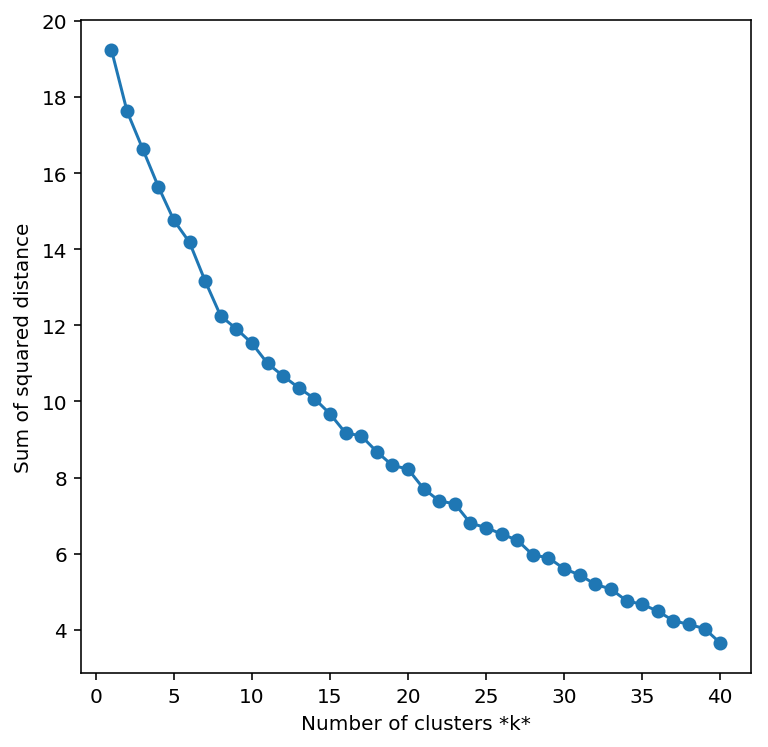

In [280]:
import matplotlib.pyplot as plt
%matplotlib inline

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

sse = [19.23935501317261,
 17.624784506155322,
 16.638534705400186,
 15.64843010836415,
 14.761824535026571,
 14.181491547220556,
 13.168106674193544,
 12.24589970702676,
 11.909306484655762,
 11.528926144241153,
 10.998663502788643,
 10.669090703433431,
 10.357746897051817,
 10.07641247602978,
 9.67471141027006,
 9.170446358164025,
 9.096543678592807,
 8.677787981935053,
 8.318063363157854,
 8.223216695433841,
 7.706701623318851,
 7.384629930460855,
 7.308479257035194,
 6.799510397340381,
 6.684754650901814,
 6.513246071204733,
 6.354507013125668,
 5.963472781707915,
 5.8906531760418375,
 5.60233476364541,
 5.439705535817639,
 5.19116959903743,
 5.0694258293864625,
 4.759818914735257,
 4.667790371367837,
 4.488720506385368,
 4.235908074178736,
 4.139359534163507,
 4.028645989881419,
 3.6519449851418053]
# saved SSE from previous runs 

list_k = list(range(31, 41))
plot_k = list(range(1, 41))

#for k in list_k:
#    print('Running KMeans for k=', k)
#    km = KMeans(n_clusters=k)
#    km.fit(toronto_grouped_clustering)
#    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(plot_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

# Not Great Clustering, no obvious K, based on plot 

The Foursquare data didn't provide any clear and obvious *elbow* where additional K's did not impact the SSE ... that is each additional K, saw a reduction in SSE.  Based on the plot (aka _elbow method_) no obvious K-Value.

You can see on the plot, however, the vertical distance shrinks pretty dramatically around 12 SSE.  Figure out which K-Value is related to that, by manually checking the SSE Array  ... that is SSE[x] - SSE[x-1] for each pair in array.  When the difference between elements makes a big change, use that K-Value.

Check the numberical delta's between SSE's

In [281]:
np.diff(sse)

array([-1.61457051, -0.9862498 , -0.9901046 , -0.88660557, -0.58033299,
       -1.01338487, -0.92220697, -0.33659322, -0.38038034, -0.53026264,
       -0.3295728 , -0.31134381, -0.28133442, -0.40170107, -0.50426505,
       -0.07390268, -0.4187557 , -0.35972462, -0.09484667, -0.51651507,
       -0.32207169, -0.07615067, -0.50896886, -0.11475575, -0.17150858,
       -0.15873906, -0.39103423, -0.07281961, -0.28831841, -0.16262923,
       -0.24853594, -0.12174377, -0.30960691, -0.09202854, -0.17906986,
       -0.25281243, -0.09654854, -0.11071354, -0.376701  ])

### Use K=8

Because the SSE delta for K=7 to K=8 is -0.92220697, and the gap from K=8 to K=9 is -0.33659322

So the steps size in the reduction of SSE is much smaller after K=8

In [286]:

# set number of clusters
kclusters = 8

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=int32)

In [295]:
# remove anglican spelleing
neighborhoods.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# not all neighborhoods got a cluster assigned ... drop them from the dataset
toronto_merged.dropna(inplace=True)
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype('int32')
toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,1,Print Shop,Fast Food Restaurant,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Women's Store
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,4,Bar,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore,Falafel Restaurant
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,1,Medical Center,Electronics Store,Pizza Place,Rental Car Location,Breakfast Spot,Intersection,Mexican Restaurant,Dog Run,Dim Sum Restaurant,Diner
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,Coffee Shop,Korean Restaurant,Women's Store,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,Fried Chicken Joint,Bakery,Hakka Restaurant,Bank,Athletics & Sports,Caribbean Restaurant,Thai Restaurant,Doner Restaurant,Diner,Discount Store


Quick sanity check to see how many neighborhoods are in each cluster

In [300]:
toronto_merged['Cluster Labels'].value_counts()

1    78
0    10
3     3
6     2
4     2
2     2
7     1
5     1
Name: Cluster Labels, dtype: int64

### Create Map

In [299]:
# create map
map_clusters = folium.Map(location=[base_lat, base_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters